***
# 3.1 First Order Syntax for Bird 22
### JX, 08/07/2022
***
    Bird22:
    LS110593.9.8.2018Araluen.WAV
    LS110640.10.1.2018Araluen.WAV
    
***

In [1]:
indv = 'Bird22'

In [2]:
## Load up Note Dataframe

import pandas as pd
from pathlib2 import Path

from butcherbird.utils.paths import DATA_DIR

SAVE_LOC = 'interim/fine_labels/butcherbird_note_df_'+indv+'_fine.pickle'
SAVE_LOC = DATA_DIR / SAVE_LOC

note_df = pd.read_pickle(SAVE_LOC)

note_df.head()

,index,phrase_nb,phrase_strt,phrase_end,phrase_len,note_cnt,note_nb,note_strt,note_end,note_len,...,key,audio,rate,spectrogram,umap,hdbscan_labels,recur_labels,recur_labels_id,lasso_labels,seq_id
0,0,0,2.37,4.24,1.87,8,0,2.370000,2.415699,0.045699,...,LS110593.9.8.2018Araluen_dn,"[0.0, -5.558967174674641e-06, -5.2225732263302...",48000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[12.999457, -3.640876]",5,5|1|0|1.0|1.0|1.0|0.0|nan,113,29,0
1,1,0,2.37,4.24,1.87,8,1,2.660000,2.977558,0.317558,...,LS110593.9.8.2018Araluen_dn,"[0.0, 3.069944854750729e-05, 4.037410245845782...",48000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[14.162895, 10.566473]",19,19|1|0|0.0|0.0|nan|nan|nan,59,21,0
2,2,0,2.37,4.24,1.87,8,2,3.079714,3.173357,0.093643,...,LS110593.9.8.2018Araluen_dn,"[0.0, 0.0030796517861769505, 0.008741865222086...",48000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[5.823101, 11.083305]",19,19|1|1|0.0|0.0|0.0|nan|nan,63,23,0
3,3,0,2.37,4.24,1.87,8,3,3.260000,3.581982,0.321982,...,LS110593.9.8.2018Araluen_dn,"[-0.0, -0.00020854328852771913, -0.00037995893...",48000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-3.8884213, 19.716284]",3,3|0|2|0.0|nan|nan|nan|nan,96,17,0
4,4,0,2.37,4.24,1.87,8,4,3.664275,3.718191,0.053916,...,LS110593.9.8.2018Araluen_dn,"[-0.0, -0.0018707999847079283, -0.003892325714...",48000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[4.6038485, 3.3076212]",7,7|1|0|0.0|0.0|nan|nan|nan,134,26,0


## Find Consistent Transitions

In [3]:
from butcherbird import sequential

In [4]:
import numpy as np

In [5]:
trans_mat = sequential.construct_seq_matrix(note_df, label = 'lasso_labels', sort = False)

In [6]:
## bootstrap null distributions with 100 samples under 0-order syntax assumption

In [7]:
p_container = []

## sample 100 times
for i in np.arange(0, 100):
    
    ## bootstrap one zero-order sequence
    bootstrapped_df = note_df.sample(n = len(note_df), replace = True).reset_index()
    
    ## find the transition matrix of the sequence
    bootstrapped_mat = sequential.construct_seq_matrix(bootstrapped_df, label = 'lasso_labels', sort = False)
    
    ## turn the matrix into long form
    bootstrapped_long = sequential.long_cvtr(bootstrapped_mat, songType = 'Bootstrapped')
    
    ## return bootstrapped distribution of all transition probabilities
    p_container.append(bootstrapped_long.p.values)
    
#p_container

In [8]:
## swap axes so that each element in p_container is a null sampling distribution of 
## find how likely that specific transition happpens with just 0 order syntax

In [9]:
p = np.swapaxes(p_container, 0, 1)

In [10]:
p

array([[0.03370787, 0.05      , 0.        , ..., 0.01923077, 0.02521008,
        0.03738318],
       [0.02247191, 0.00833333, 0.        , ..., 0.01923077, 0.02521008,
        0.01869159],
       [0.01123596, 0.03333333, 0.01851852, ..., 0.00961538, 0.01680672,
        0.01869159],
       ...,
       [0.00581395, 0.02639296, 0.00980392, ..., 0.00898204, 0.00653595,
        0.00321543],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.10174419, 0.07624633, 0.07189542, ..., 0.11676647, 0.07189542,
        0.09324759]])

In [11]:
import numpy as np
import scipy.stats

## a standard calculation for confidence interval
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [12]:
higherconfints = []

for null_transitions in p:
    higherconfints.append(mean_confidence_interval(null_transitions, confidence = 0.95)[2])
    
#higherconfints

In [13]:
trans_long = sequential.long_cvtr(trans_mat, songType = 'True')

In [14]:
trans_long

,songType,noteType,markov,p
0,True,0,0,0.00000
1,True,0,1,0.00000
2,True,0,2,0.00000
3,True,0,3,0.87619
4,True,0,4,0.00000
...,...,...,...,...
1516,True,38,34,0.00000
1517,True,38,35,0.00000
1518,True,38,36,0.00000
1519,True,38,37,0.00000


In [15]:
trans_long['higherconfint'] = higherconfints

In [16]:
trans_long

,songType,noteType,markov,p,higherconfint
0,True,0,0,0.00000,0.032720
1,True,0,1,0.00000,0.011507
2,True,0,2,0.00000,0.026725
3,True,0,3,0.87619,0.030634
4,True,0,4,0.00000,0.005461
...,...,...,...,...,...
1516,True,38,34,0.00000,0.001202
1517,True,38,35,0.00000,0.001055
1518,True,38,36,0.00000,0.012792
1519,True,38,37,0.00000,0.000536


In [17]:
filtered_trans_long = trans_long[trans_long.p > trans_long.higherconfint]

In [18]:
filtered_trans_long

,songType,noteType,markov,p,higherconfint
3,True,0,3,0.876190,0.030634
48,True,1,9,0.029412,0.020358
49,True,1,10,0.294118,0.038025
59,True,1,20,0.088235,0.037287
62,True,1,23,0.205882,0.098515
...,...,...,...,...,...
1487,True,38,5,0.026866,0.020708
1493,True,38,11,0.140299,0.021884
1496,True,38,14,0.235821,0.029008
1498,True,38,16,0.259701,0.027146


In [19]:
ftl = filtered_trans_long

## Rhythm Dyadic Analysis

In [20]:
## load rhythm analyzer
import butcherbird.rhythm as rhythm

/home/AD/j8xing/syntax_rhythm_pbb/butcherbird/rhythm.py:300: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [21]:
dyadic = rhythm.construct_rhythm_df(note_df, 'lasso_labels')

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/431 [00:00<?, ?it/s]

  0%|          | 0/431 [00:00<?, ?it/s]

In [22]:
dyadic

,intervals1,intervals2,label1,label2,label3,len1,len2,len3,s_interval,l_interval,cycle_dur,ratio_roeske,ratio_custom,cycle_rank
0,0.075725,0.196397,26,6,12,0.053916,0.165477,0.100737,0.075725,0.196397,0.272123,0.278276,0.385572,1
1,0.196397,0.203603,6,12,11,0.165477,0.100737,0.100000,0.196397,0.203603,0.400000,0.490994,0.964612,2
2,0.404275,0.075725,17,26,6,0.321982,0.053916,0.165477,0.075725,0.404275,0.480000,0.842239,0.187311,3
3,0.180286,0.404275,23,17,26,0.093643,0.321982,0.053916,0.180286,0.404275,0.584561,0.308413,0.445949,4
4,0.419714,0.180286,21,23,17,0.317558,0.093643,0.321982,0.180286,0.419714,0.600000,0.699524,0.429544,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2300,0.164585,0.358590,23,2,7,0.100264,0.281875,0.074628,0.164585,0.358590,0.523175,0.314589,0.458979,6
2301,0.177804,0.350000,38,16,25,0.049186,0.280000,0.054864,0.177804,0.350000,0.527804,0.336876,0.508013,7
2302,0.480513,0.355655,24,24,4,0.227014,0.215663,0.692392,0.355655,0.480513,0.836168,0.574661,0.740157,1
2303,0.696176,0.273891,4,6,8,0.692392,0.183891,0.134733,0.273891,0.696176,0.970067,0.717657,0.393423,2


In [23]:
ftl

,songType,noteType,markov,p,higherconfint
3,True,0,3,0.876190,0.030634
48,True,1,9,0.029412,0.020358
49,True,1,10,0.294118,0.038025
59,True,1,20,0.088235,0.037287
62,True,1,23,0.205882,0.098515
...,...,...,...,...,...
1487,True,38,5,0.026866,0.020708
1493,True,38,11,0.140299,0.021884
1496,True,38,14,0.235821,0.029008
1498,True,38,16,0.259701,0.027146


In [24]:
## verify rhythm counts above 0.01 of total rhythm count (8013 * 0.01)

In [25]:
verified = []

for index, transition in ftl.iterrows():
    note = transition.noteType
    dest = transition.markov
    
    ## find if dyadic contains enough entries for this particular combination
    first_filter = dyadic[dyadic.label1 == note]
    second_filter = first_filter[first_filter.label2 == dest]
    
    if len(second_filter) > 0.01*len(dyadic):
        verified.append(index)

In [26]:
vr = ftl.filter(items = verified, axis = 0)

In [27]:
unique, counts = np.unique(vr.noteType, return_counts = True)

In [28]:
eligible_notes = []
for noteType, count in zip(unique, counts):
    if count > 1:
        eligible_notes.append(noteType)

In [29]:
eligible_transitions = []

for n in eligible_notes:
    eligible_transitions.append(vr[vr.noteType == n])
    
eligible_transitions = pd.concat(eligible_transitions)

In [30]:
eligible_transitions

,songType,noteType,markov,p,higherconfint
249,True,6,15,0.317204,0.025084
272,True,6,38,0.408602,0.101872
637,True,16,13,0.428571,0.015365
649,True,16,25,0.527473,0.017424
689,True,17,26,0.271318,0.021207
691,True,17,28,0.581395,0.049308
842,True,21,23,0.369963,0.094880
848,True,21,29,0.241758,0.074920
899,True,23,2,0.289389,0.027721
914,True,23,17,0.382637,0.039089


In [31]:
import scipy.stats
import itertools

def bif_rhythm_ks(vd_bif, dyadic, mode = 'ratio_roeske'):
    '''
    Calculate KS test for each bifurcation point
    '''
    
    output = []
    
    # 1. Extract Bifurcation Info from vd_bif
    ### a. Find all pre-bifurcation notes
    pre_bif = np.unique(vd_bif['noteType'])
    
    # 2. For each bifurcation, conduct a Kolmogorov-Smirnov test
    ### a. for each bifurcation
    for note in pre_bif:
        ### a. Query its exact slice
        bif_df = vd_bif[vd_bif['noteType'] == note]
        ### b. Query its bifurcation destinations
        destinations = np.unique(bif_df['markov'])
        pairs = list(itertools.combinations(destinations, 2))
        ### c. Filter dyadic by pre_bif
        note_df = dyadic[dyadic['label1'] == note]
        ### d. Filter note_df by bif destinations
        for pair in pairs: 
            t1_df = note_df[note_df['label2'] == pair[0]]
            t2_df = note_df[note_df['label2'] == pair[1]]
            bif_prob0 = bif_df[bif_df['markov'] == pair[0]]['p'].values[0]
            bif_prob1 = bif_df[bif_df['markov'] == pair[1]]['p'].values[0]
            
            ### e. compute ks
            try:
                ks = scipy.stats.ks_2samp(t1_df[mode], t2_df[mode])
            except:
                ks = [None, None]
                print('ks not computed')
            ### e. feeds out pandas
            output.append(
                pd.DataFrame(
                    {
                        'pre_bif': [note],
                        'bif_des': [(pair[0], pair[1])],
                        'bif_prof': [
                            (
                                bif_prob0,
                                bif_prob1
                            )
                        ],
                        'rhy_cnts': [
                            (
                                len(t1_df),
                                len(t2_df)
                            )
                        ],
                        'ks_statistic': [ks[0]],
                        'ks_p': [ks[1]]
                    }
                )
            )
        
        print('Finished querying bifurcation with pre_bif ', note)
    return pd.concat(output)

In [32]:
entangle = bif_rhythm_ks(eligible_transitions, dyadic)

Finished querying bifurcation with pre_bif  6
Finished querying bifurcation with pre_bif  16
Finished querying bifurcation with pre_bif  17
Finished querying bifurcation with pre_bif  21
Finished querying bifurcation with pre_bif  23
Finished querying bifurcation with pre_bif  24
Finished querying bifurcation with pre_bif  28
Finished querying bifurcation with pre_bif  38


In [33]:
entangle

,pre_bif,bif_des,bif_prof,rhy_cnts,ks_statistic,ks_p
0,6,"(15, 38)","(0.3172043010752688, 0.40860215053763443)","(59, 75)",0.986667,2.071676e-37
0,16,"(13, 25)","(0.42857142857142855, 0.5274725274725275)","(39, 48)",0.751603,2.109416e-12
0,17,"(26, 28)","(0.2713178294573643, 0.5813953488372093)","(34, 75)",0.134118,7.335003e-01
0,21,"(23, 29)","(0.36996336996337, 0.24175824175824176)","(100, 66)",0.974848,9.869535e-44
0,23,"(2, 17)","(0.28938906752411575, 0.38263665594855306)","(90, 117)",0.264957,1.217930e-03
0,23,"(2, 27)","(0.28938906752411575, 0.08360128617363344)","(90, 25)",1.000000,1.575693e-25
0,23,"(2, 36)","(0.28938906752411575, 0.10289389067524116)","(90, 32)",1.000000,7.917690e-30
0,23,"(17, 27)","(0.38263665594855306, 0.08360128617363344)","(117, 25)",1.000000,4.569218e-28
0,23,"(17, 36)","(0.38263665594855306, 0.10289389067524116)","(117, 32)",1.000000,5.485083e-33
0,23,"(27, 36)","(0.08360128617363344, 0.10289389067524116)","(25, 32)",0.145000,8.761763e-01


In [34]:
entangle['ks_p'] < 0.001

0     True
0     True
0    False
0     True
0    False
0     True
0     True
0     True
0     True
0    False
0     True
0    False
0     True
Name: ks_p, dtype: bool

In [35]:
## bonferroni correct

In [36]:
import statsmodels.stats.multitest

In [37]:
entangle['bonferroni_p'] = statsmodels.stats.multitest.multipletests(entangle['ks_p'].values, alpha = 0.05, method = 'bonferroni')[1]

In [38]:
entangle

,pre_bif,bif_des,bif_prof,rhy_cnts,ks_statistic,ks_p,bonferroni_p
0,6,"(15, 38)","(0.3172043010752688, 0.40860215053763443)","(59, 75)",0.986667,2.071676e-37,2.693178e-36
0,16,"(13, 25)","(0.42857142857142855, 0.5274725274725275)","(39, 48)",0.751603,2.109416e-12,2.742240e-11
0,17,"(26, 28)","(0.2713178294573643, 0.5813953488372093)","(34, 75)",0.134118,7.335003e-01,1.000000e+00
0,21,"(23, 29)","(0.36996336996337, 0.24175824175824176)","(100, 66)",0.974848,9.869535e-44,1.283040e-42
0,23,"(2, 17)","(0.28938906752411575, 0.38263665594855306)","(90, 117)",0.264957,1.217930e-03,1.583309e-02
0,23,"(2, 27)","(0.28938906752411575, 0.08360128617363344)","(90, 25)",1.000000,1.575693e-25,2.048401e-24
0,23,"(2, 36)","(0.28938906752411575, 0.10289389067524116)","(90, 32)",1.000000,7.917690e-30,1.029300e-28
0,23,"(17, 27)","(0.38263665594855306, 0.08360128617363344)","(117, 25)",1.000000,4.569218e-28,5.939983e-27
0,23,"(17, 36)","(0.38263665594855306, 0.10289389067524116)","(117, 32)",1.000000,5.485083e-33,7.130608e-32
0,23,"(27, 36)","(0.08360128617363344, 0.10289389067524116)","(25, 32)",0.145000,8.761763e-01,1.000000e+00


In [39]:
entangle['bonferroni_p'] < 0.001

0     True
0     True
0    False
0     True
0    False
0     True
0     True
0     True
0     True
0    False
0     True
0    False
0     True
Name: bonferroni_p, dtype: bool

In [40]:
## do a shuffle
dyadic_shuffle = dyadic.copy(deep = True)
np.random.shuffle(dyadic_shuffle['ratio_roeske'].values)
entangle_shuffled = bif_rhythm_ks(eligible_transitions, dyadic_shuffle)

Finished querying bifurcation with pre_bif  6
Finished querying bifurcation with pre_bif  16
Finished querying bifurcation with pre_bif  17
Finished querying bifurcation with pre_bif  21
Finished querying bifurcation with pre_bif  23
Finished querying bifurcation with pre_bif  24
Finished querying bifurcation with pre_bif  28
Finished querying bifurcation with pre_bif  38


In [41]:
entangle_shuffled

,pre_bif,bif_des,bif_prof,rhy_cnts,ks_statistic,ks_p
0,6,"(15, 38)","(0.3172043010752688, 0.40860215053763443)","(59, 75)",0.129040,0.583045
0,16,"(13, 25)","(0.42857142857142855, 0.5274725274725275)","(39, 48)",0.128205,0.815158
0,17,"(26, 28)","(0.2713178294573643, 0.5813953488372093)","(34, 75)",0.135686,0.718111
0,21,"(23, 29)","(0.36996336996337, 0.24175824175824176)","(100, 66)",0.070303,0.977991
0,23,"(2, 17)","(0.28938906752411575, 0.38263665594855306)","(90, 117)",0.087179,0.796022
0,23,"(2, 27)","(0.28938906752411575, 0.08360128617363344)","(90, 25)",0.260000,0.117705
0,23,"(2, 36)","(0.28938906752411575, 0.10289389067524116)","(90, 32)",0.162500,0.499453
0,23,"(17, 27)","(0.38263665594855306, 0.08360128617363344)","(117, 25)",0.190769,0.383519
0,23,"(17, 36)","(0.38263665594855306, 0.10289389067524116)","(117, 32)",0.169338,0.413175
0,23,"(27, 36)","(0.08360128617363344, 0.10289389067524116)","(25, 32)",0.268750,0.213626


# Compute Global Statistic

The concept of the global statistic here is to compare the rhythm ratios for each first-order syntax and to compare between-group variation / within-group variation. 

1. Find each first-order transition -> z-score -> compile all first-order transition -> MSE
2. Compare with zero-order transition -> z-score -> compile all first-order transition -> MSE
3. Is first-order transition variance is lower than zero-order transition variance?

## Let's find all the first-order transitions first

In [42]:
import scipy.stats as stats

In [43]:
def syntactic_rhythmic_modulation_metric (dyadic):
    
    ## compute global metric
    
    first_order_rhythms_centered = []
    first_order_group_n = 0

    ## for every possible label
    for label in np.unique(dyadic['label1']):

        ## find a sub dataframe containing only designated zero-order label
        zero_order = dyadic[dyadic['label1'] == label]

        ## for every possible transition of that label
        for transition in np.unique(zero_order['label2']):

            ## find its rhythms
            first_order = zero_order[zero_order['label2'] == transition]
            first_order_rhythms = first_order['ratio_roeske'].values
            first_order_rhythms_centered.extend(first_order_rhythms - np.mean(first_order_rhythms))

            ## add 1 to group_n
            first_order_group_n+=1
    
    # find MSE
    MSE_first = sum(np.square(first_order_rhythms_centered)) / len(dyadic)
    MSE_baseline = sum(np.square(dyadic['ratio_roeske'].values - np.mean(dyadic['ratio_roeske']))) / len(dyadic)
    
    return 1 - MSE_first / MSE_baseline

## empirical 

In [44]:
syntactic_rhythmic_modulation_metric(dyadic)

0.9489121244185548

## Find Baseline using bootstrap

In [45]:
from tqdm.autonotebook import tqdm

In [46]:
dyadic_shuffle = dyadic.copy(deep = True)

SDoMSE = []

for sample in tqdm(np.arange(0, 100)):
    
    ## shuffle dyadic
    np.random.shuffle(dyadic_shuffle['ratio_roeske'].values)
    
    SDoMSE.append(syntactic_rhythmic_modulation_metric(dyadic_shuffle))

  0%|          | 0/100 [00:00<?, ?it/s]

In [47]:
mean_confidence_interval(SDoMSE, confidence=0.95)

(0.06573795872216494, 0.06451638990512222, 0.06695952753920766)

## Output Graphs for every analyzed transition

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [49]:
entangle

,pre_bif,bif_des,bif_prof,rhy_cnts,ks_statistic,ks_p,bonferroni_p
0,6,"(15, 38)","(0.3172043010752688, 0.40860215053763443)","(59, 75)",0.986667,2.071676e-37,2.693178e-36
0,16,"(13, 25)","(0.42857142857142855, 0.5274725274725275)","(39, 48)",0.751603,2.109416e-12,2.742240e-11
0,17,"(26, 28)","(0.2713178294573643, 0.5813953488372093)","(34, 75)",0.134118,7.335003e-01,1.000000e+00
0,21,"(23, 29)","(0.36996336996337, 0.24175824175824176)","(100, 66)",0.974848,9.869535e-44,1.283040e-42
0,23,"(2, 17)","(0.28938906752411575, 0.38263665594855306)","(90, 117)",0.264957,1.217930e-03,1.583309e-02
0,23,"(2, 27)","(0.28938906752411575, 0.08360128617363344)","(90, 25)",1.000000,1.575693e-25,2.048401e-24
0,23,"(2, 36)","(0.28938906752411575, 0.10289389067524116)","(90, 32)",1.000000,7.917690e-30,1.029300e-28
0,23,"(17, 27)","(0.38263665594855306, 0.08360128617363344)","(117, 25)",1.000000,4.569218e-28,5.939983e-27
0,23,"(17, 36)","(0.38263665594855306, 0.10289389067524116)","(117, 32)",1.000000,5.485083e-33,7.130608e-32
0,23,"(27, 36)","(0.08360128617363344, 0.10289389067524116)","(25, 32)",0.145000,8.761763e-01,1.000000e+00


In [50]:
note_types = entangle['pre_bif'].values
destinations = entangle['bif_des'].values

In [51]:
## shuffle dyadic
time_info = dyadic[['intervals1', 
                   'intervals2',
                   's_interval',
                   'l_interval',
                   'cycle_dur',
                   'ratio_roeske',
                   'ratio_custom',
                   'cycle_rank'
                  ]]

syntax_info = dyadic[['label1',
                      'label2',
                      'label3'
                  ]]

bootstrapped_time_info = time_info.sample(frac = 100, replace = True).reset_index(drop = True)
bootstrapped_syntax_info = syntax_info.sample(frac = 100, replace = True).reset_index(drop = True)
dyadic_shuffle = bootstrapped_time_info.join(bootstrapped_syntax_info)

/tmp/ipykernel_27404/346327623.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2 = pos1[pos1['label2'] == destination[0]].append(pos1[pos1['label2'] == destination[1]])
/tmp/ipykernel_27404/346327623.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2_shuffle = pos1_shuffle[pos1_shuffle['label2'] == destination[0]].append(pos1_shuffle[pos1_shuffle['label2'] == destination[1]])


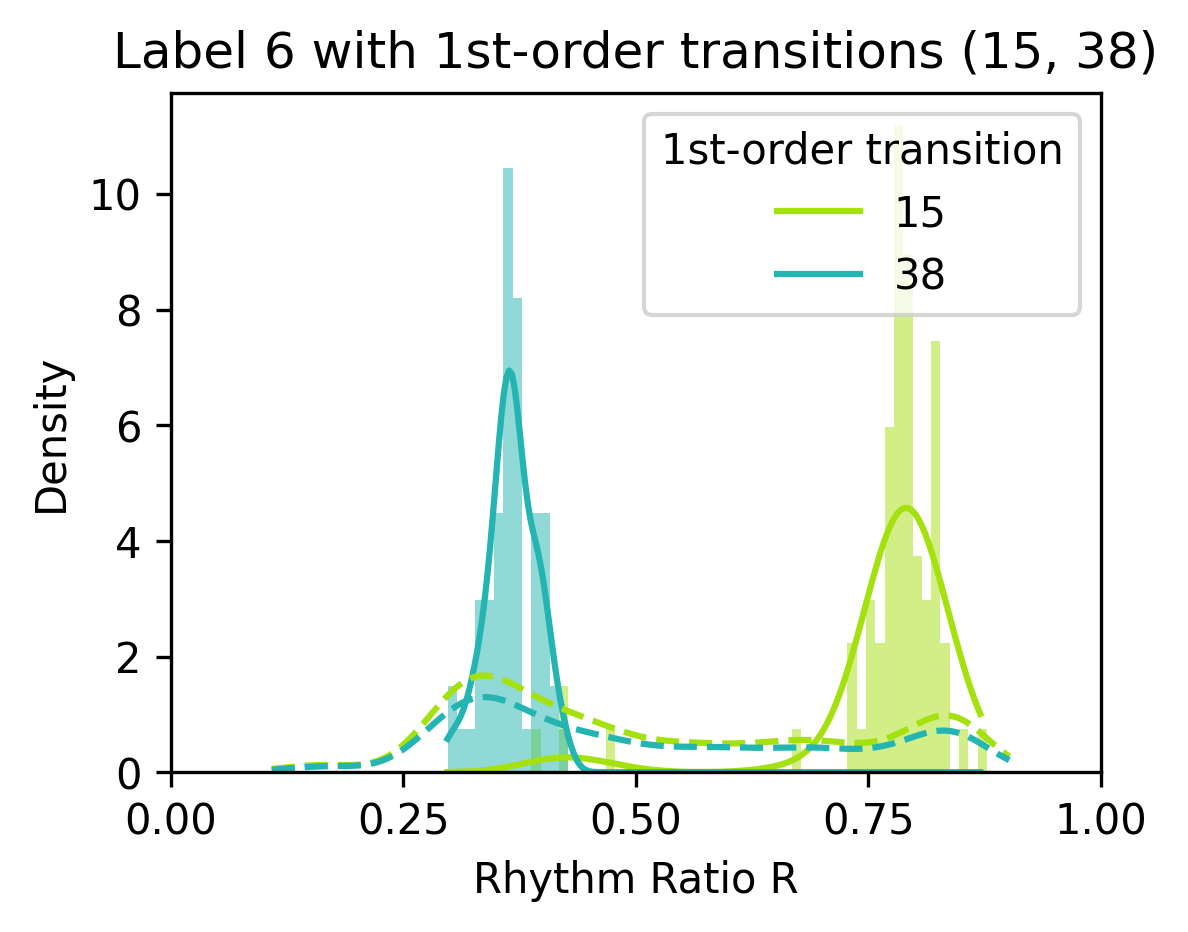

/tmp/ipykernel_27404/346327623.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2 = pos1[pos1['label2'] == destination[0]].append(pos1[pos1['label2'] == destination[1]])
/tmp/ipykernel_27404/346327623.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2_shuffle = pos1_shuffle[pos1_shuffle['label2'] == destination[0]].append(pos1_shuffle[pos1_shuffle['label2'] == destination[1]])


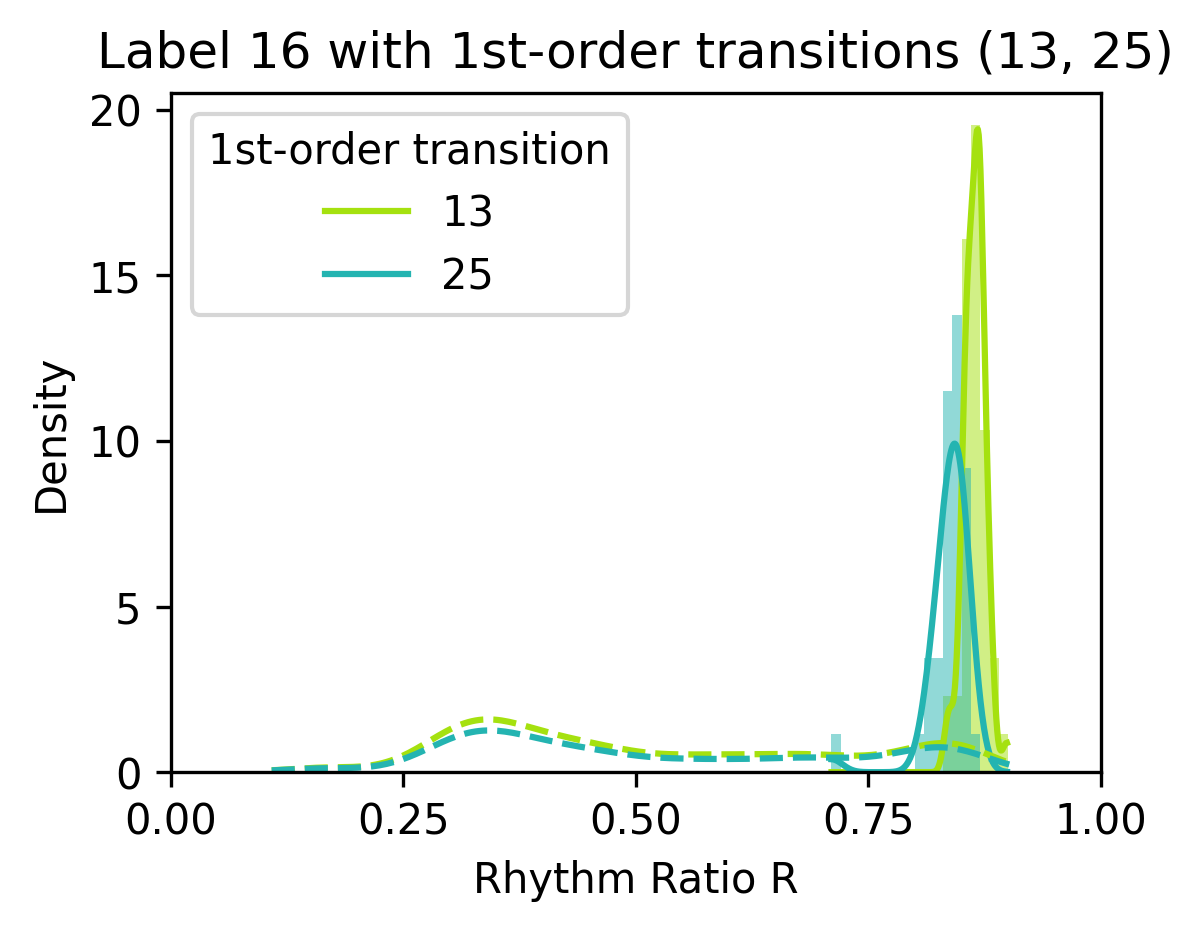

/tmp/ipykernel_27404/346327623.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2 = pos1[pos1['label2'] == destination[0]].append(pos1[pos1['label2'] == destination[1]])
/tmp/ipykernel_27404/346327623.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2_shuffle = pos1_shuffle[pos1_shuffle['label2'] == destination[0]].append(pos1_shuffle[pos1_shuffle['label2'] == destination[1]])


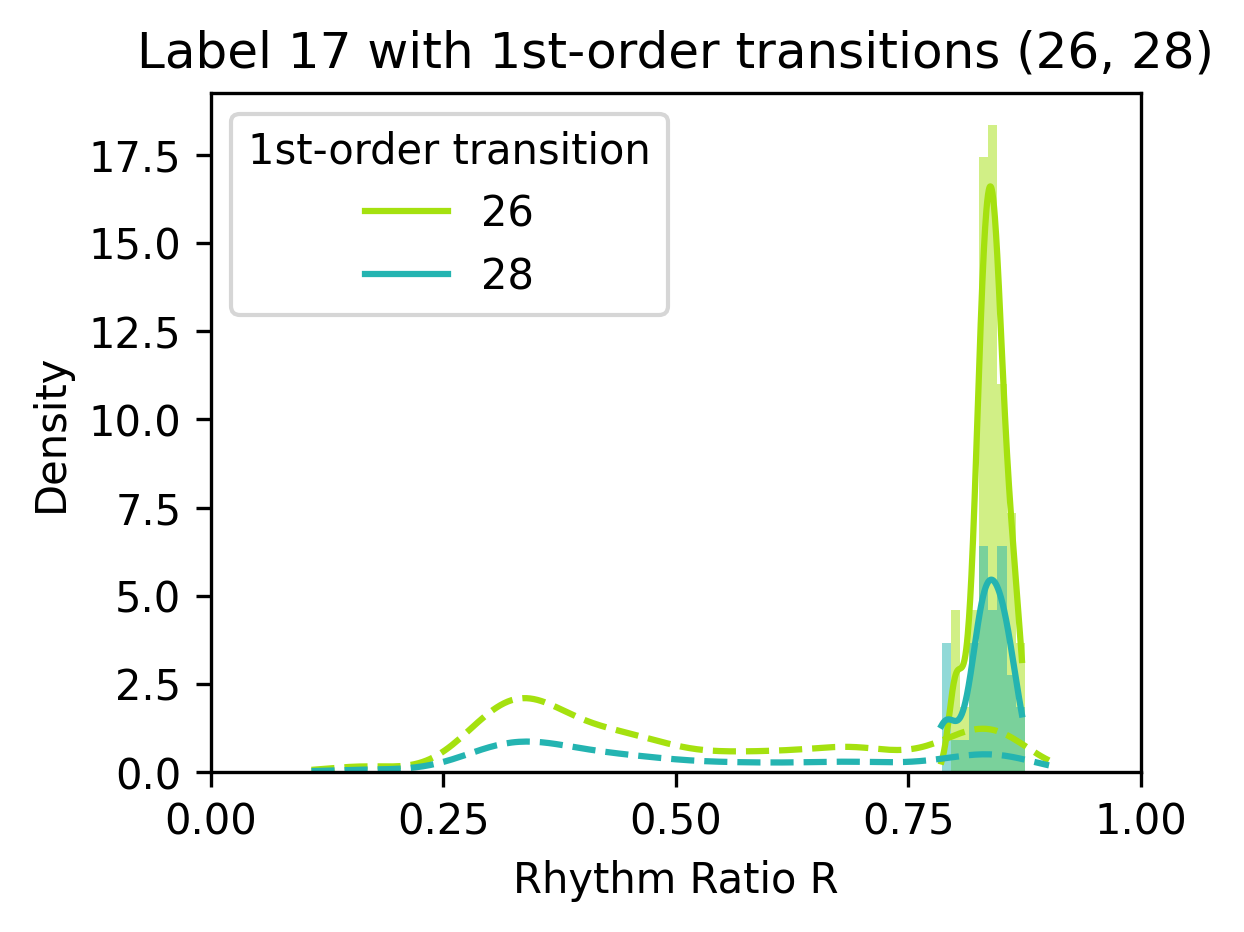

/tmp/ipykernel_27404/346327623.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2 = pos1[pos1['label2'] == destination[0]].append(pos1[pos1['label2'] == destination[1]])
/tmp/ipykernel_27404/346327623.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2_shuffle = pos1_shuffle[pos1_shuffle['label2'] == destination[0]].append(pos1_shuffle[pos1_shuffle['label2'] == destination[1]])


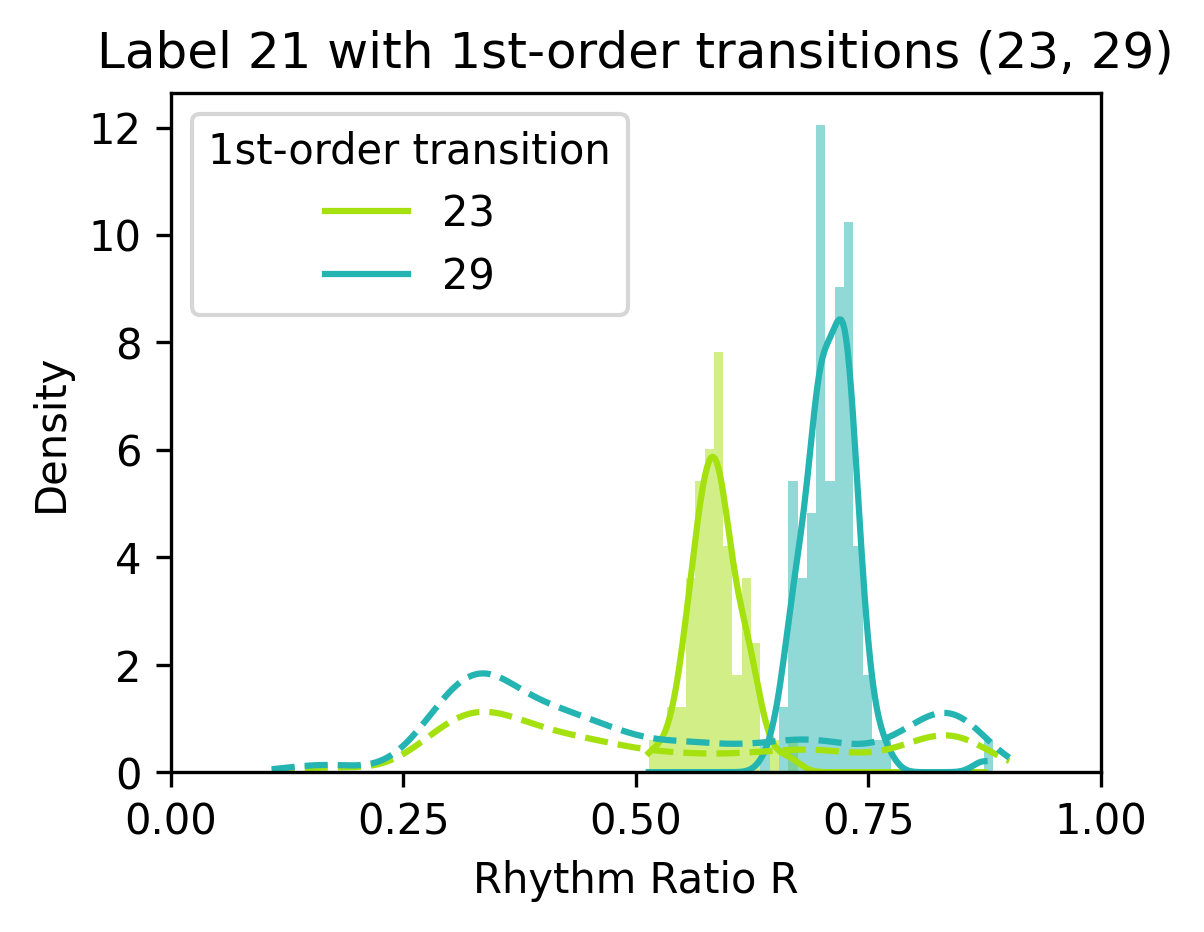

/tmp/ipykernel_27404/346327623.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2 = pos1[pos1['label2'] == destination[0]].append(pos1[pos1['label2'] == destination[1]])
/tmp/ipykernel_27404/346327623.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2_shuffle = pos1_shuffle[pos1_shuffle['label2'] == destination[0]].append(pos1_shuffle[pos1_shuffle['label2'] == destination[1]])


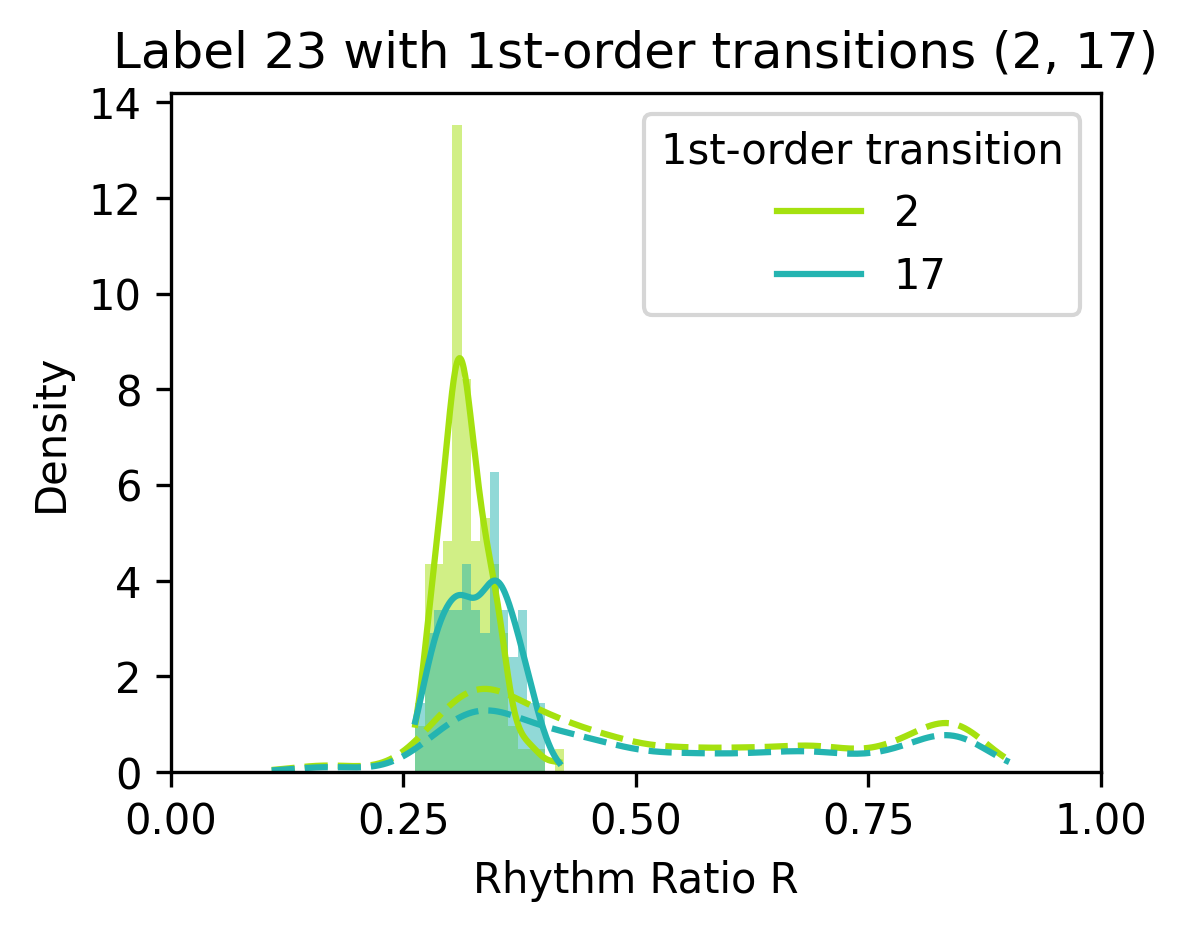

/tmp/ipykernel_27404/346327623.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2 = pos1[pos1['label2'] == destination[0]].append(pos1[pos1['label2'] == destination[1]])
/tmp/ipykernel_27404/346327623.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2_shuffle = pos1_shuffle[pos1_shuffle['label2'] == destination[0]].append(pos1_shuffle[pos1_shuffle['label2'] == destination[1]])


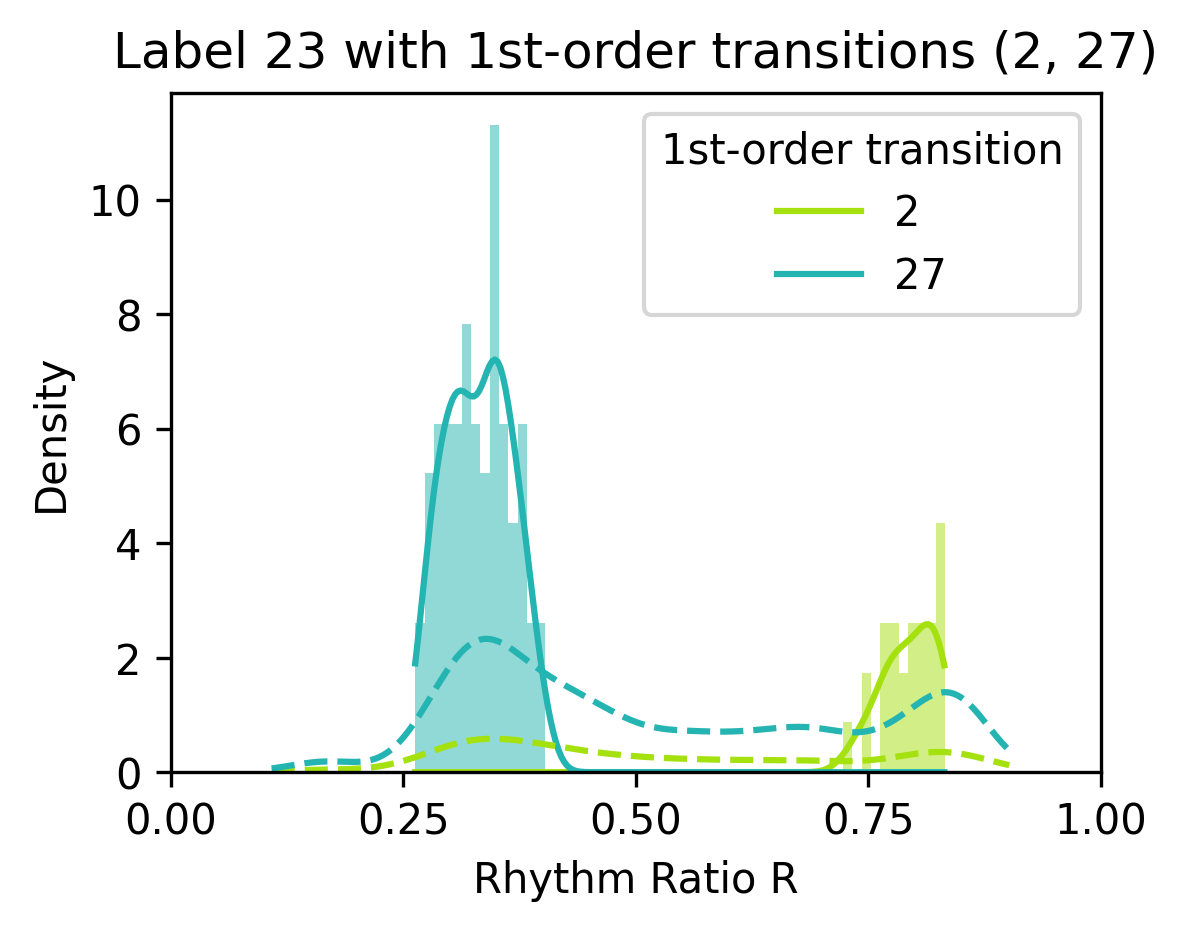

/tmp/ipykernel_27404/346327623.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2 = pos1[pos1['label2'] == destination[0]].append(pos1[pos1['label2'] == destination[1]])
/tmp/ipykernel_27404/346327623.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2_shuffle = pos1_shuffle[pos1_shuffle['label2'] == destination[0]].append(pos1_shuffle[pos1_shuffle['label2'] == destination[1]])


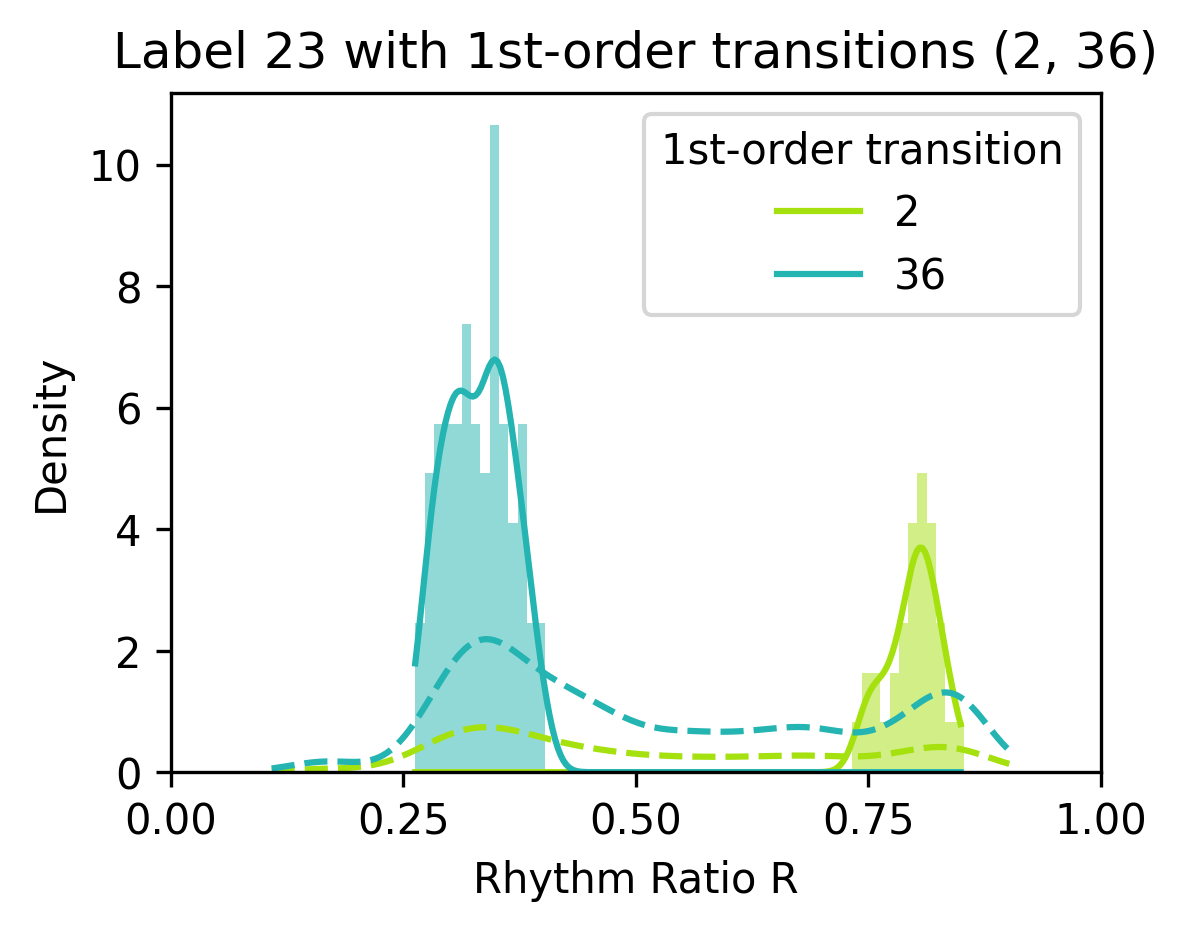

/tmp/ipykernel_27404/346327623.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2 = pos1[pos1['label2'] == destination[0]].append(pos1[pos1['label2'] == destination[1]])
/tmp/ipykernel_27404/346327623.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2_shuffle = pos1_shuffle[pos1_shuffle['label2'] == destination[0]].append(pos1_shuffle[pos1_shuffle['label2'] == destination[1]])


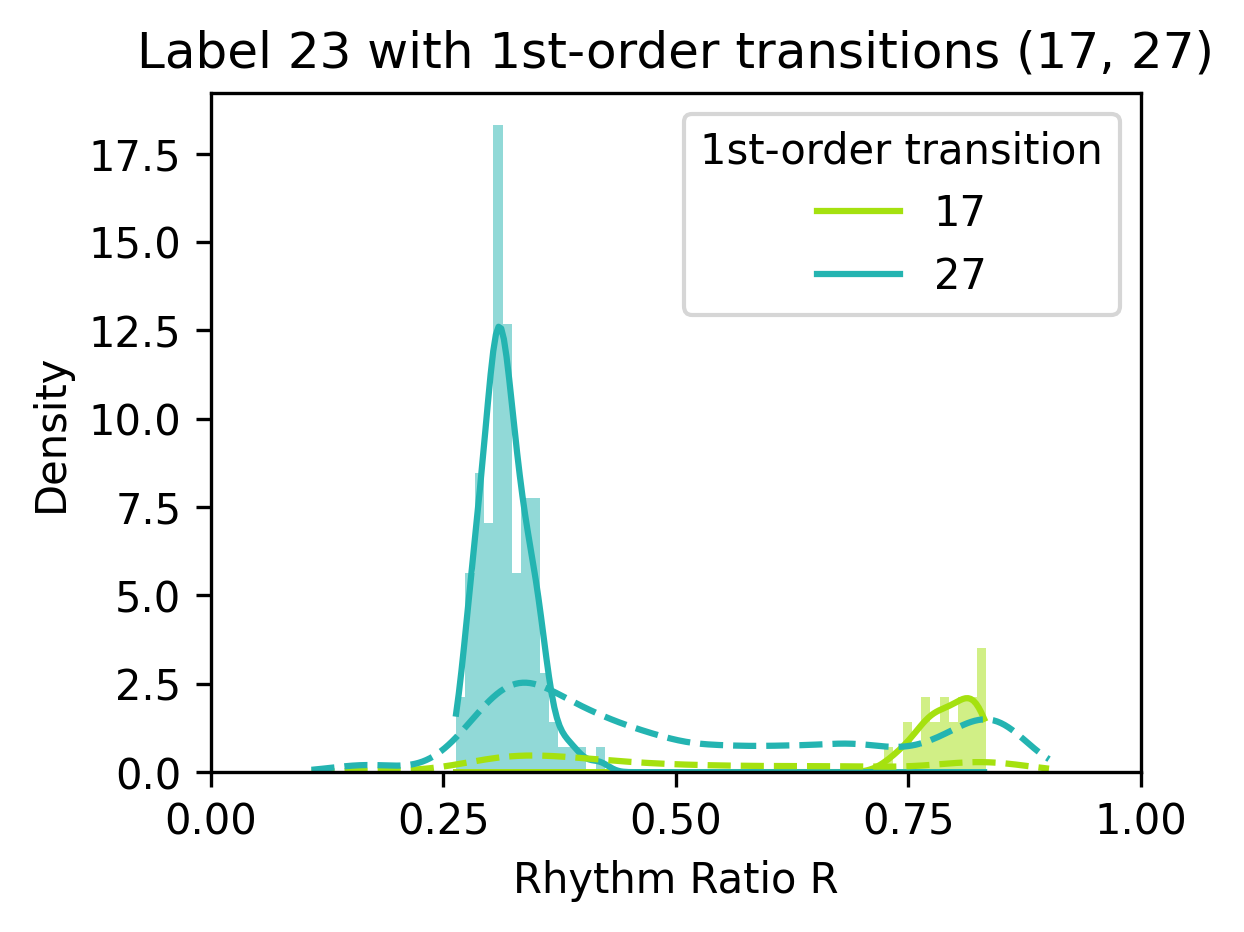

/tmp/ipykernel_27404/346327623.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2 = pos1[pos1['label2'] == destination[0]].append(pos1[pos1['label2'] == destination[1]])
/tmp/ipykernel_27404/346327623.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2_shuffle = pos1_shuffle[pos1_shuffle['label2'] == destination[0]].append(pos1_shuffle[pos1_shuffle['label2'] == destination[1]])


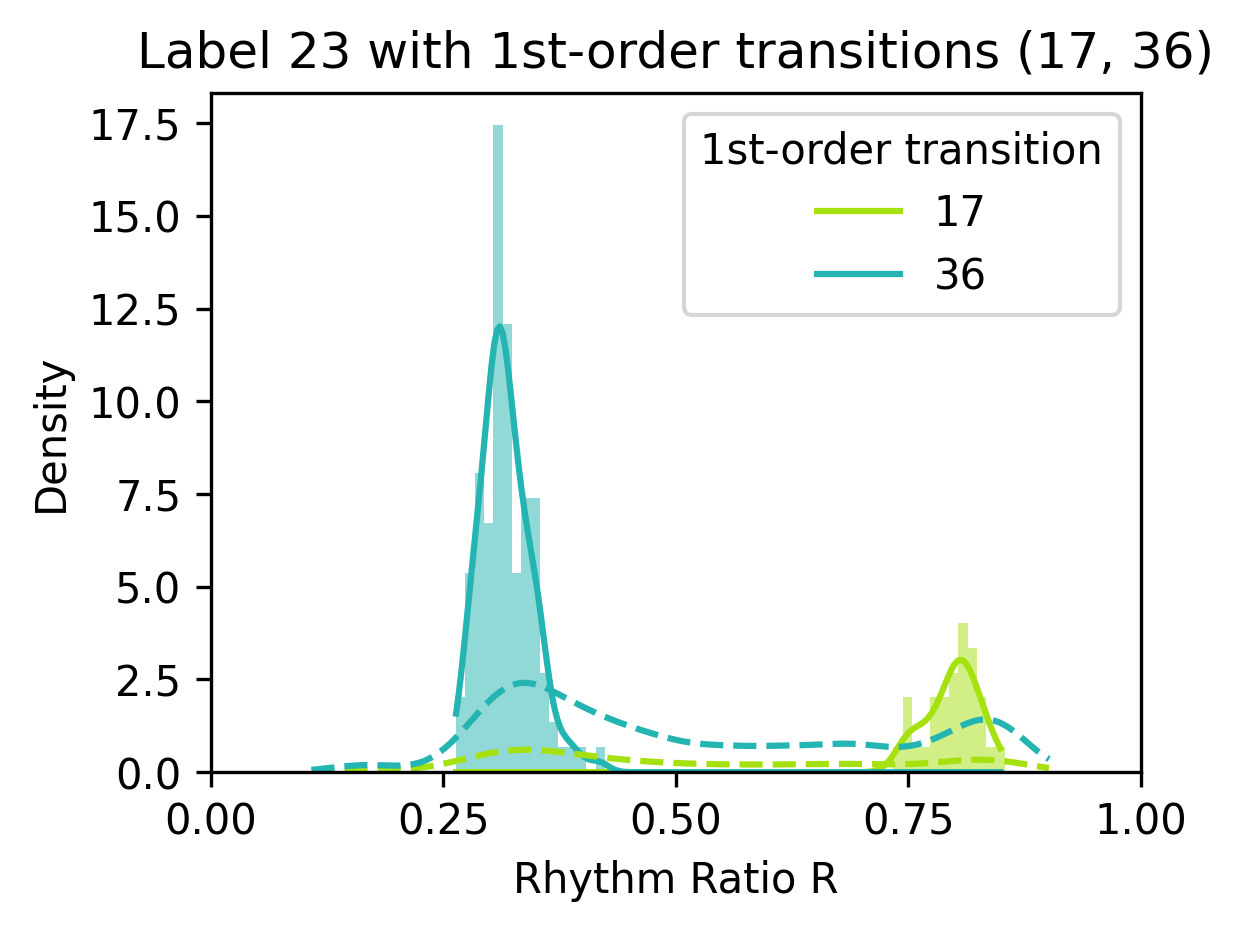

/tmp/ipykernel_27404/346327623.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2 = pos1[pos1['label2'] == destination[0]].append(pos1[pos1['label2'] == destination[1]])
/tmp/ipykernel_27404/346327623.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2_shuffle = pos1_shuffle[pos1_shuffle['label2'] == destination[0]].append(pos1_shuffle[pos1_shuffle['label2'] == destination[1]])


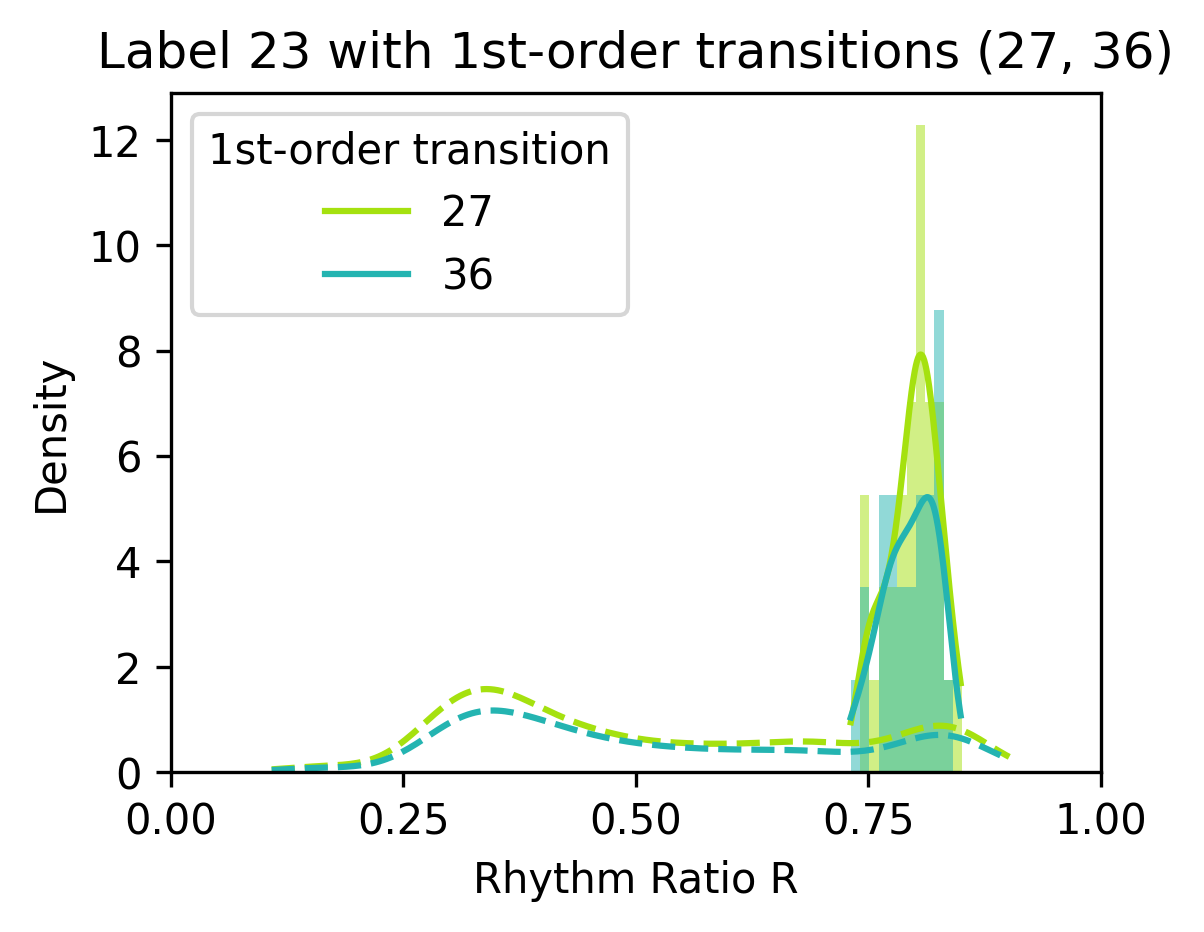

/tmp/ipykernel_27404/346327623.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2 = pos1[pos1['label2'] == destination[0]].append(pos1[pos1['label2'] == destination[1]])
/tmp/ipykernel_27404/346327623.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2_shuffle = pos1_shuffle[pos1_shuffle['label2'] == destination[0]].append(pos1_shuffle[pos1_shuffle['label2'] == destination[1]])


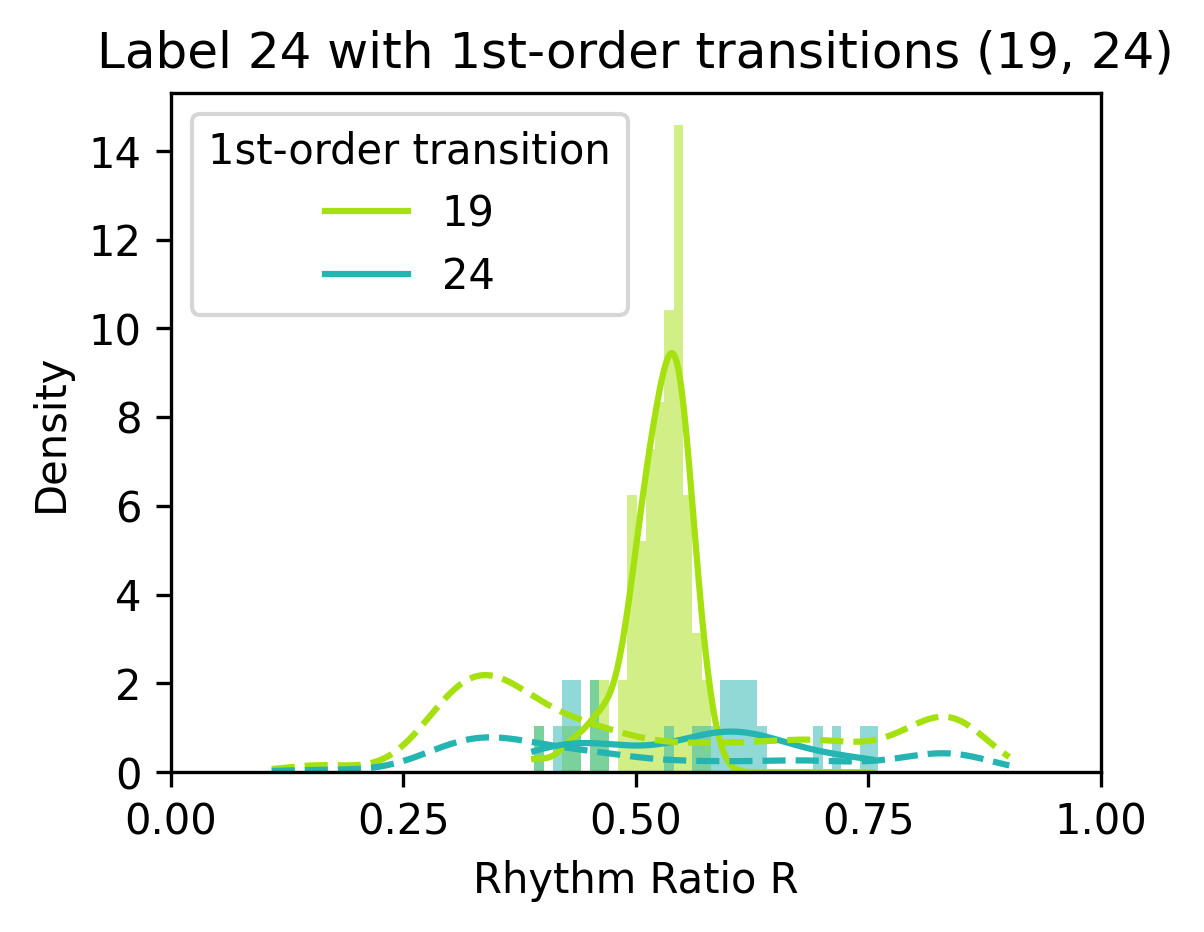

/tmp/ipykernel_27404/346327623.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2 = pos1[pos1['label2'] == destination[0]].append(pos1[pos1['label2'] == destination[1]])
/tmp/ipykernel_27404/346327623.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2_shuffle = pos1_shuffle[pos1_shuffle['label2'] == destination[0]].append(pos1_shuffle[pos1_shuffle['label2'] == destination[1]])


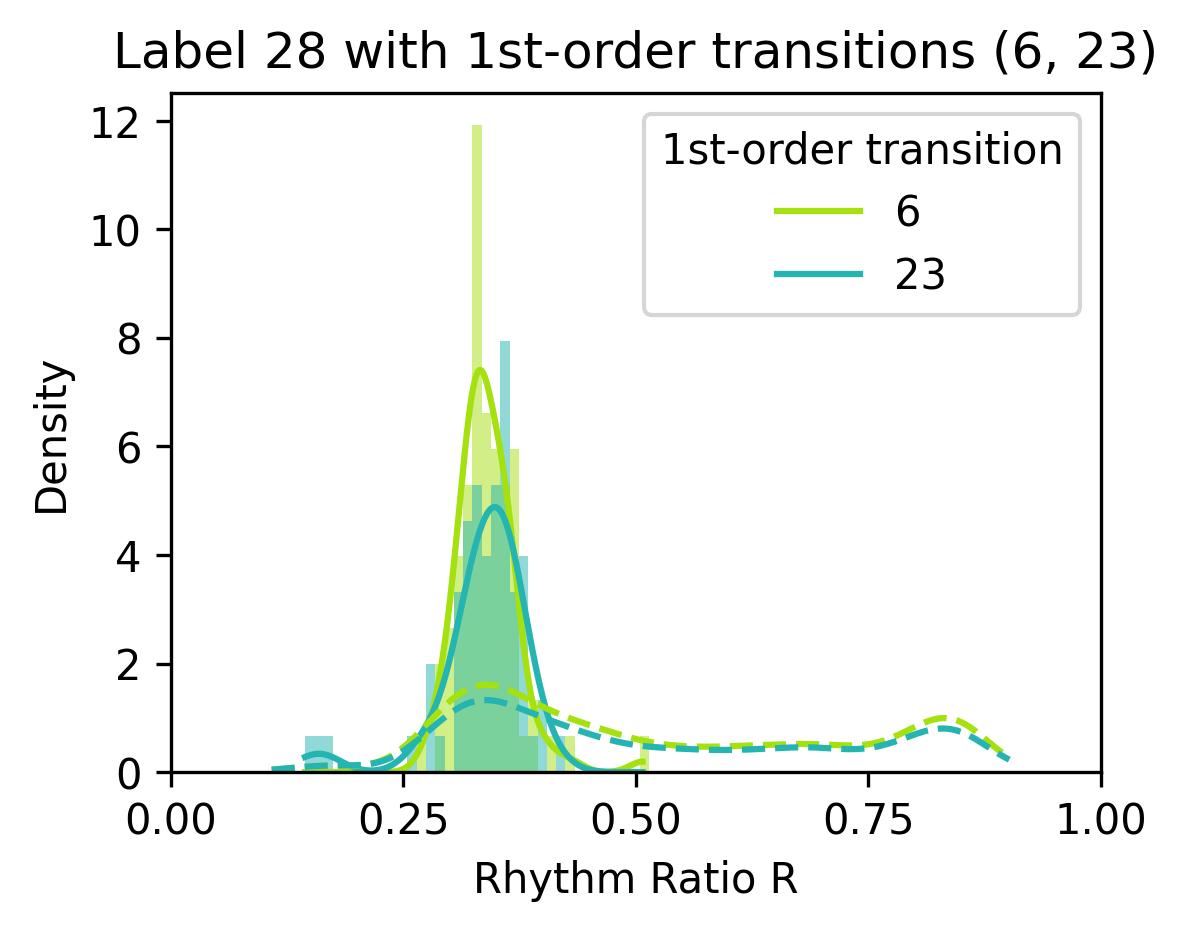

/tmp/ipykernel_27404/346327623.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2 = pos1[pos1['label2'] == destination[0]].append(pos1[pos1['label2'] == destination[1]])
/tmp/ipykernel_27404/346327623.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos2_shuffle = pos1_shuffle[pos1_shuffle['label2'] == destination[0]].append(pos1_shuffle[pos1_shuffle['label2'] == destination[1]])


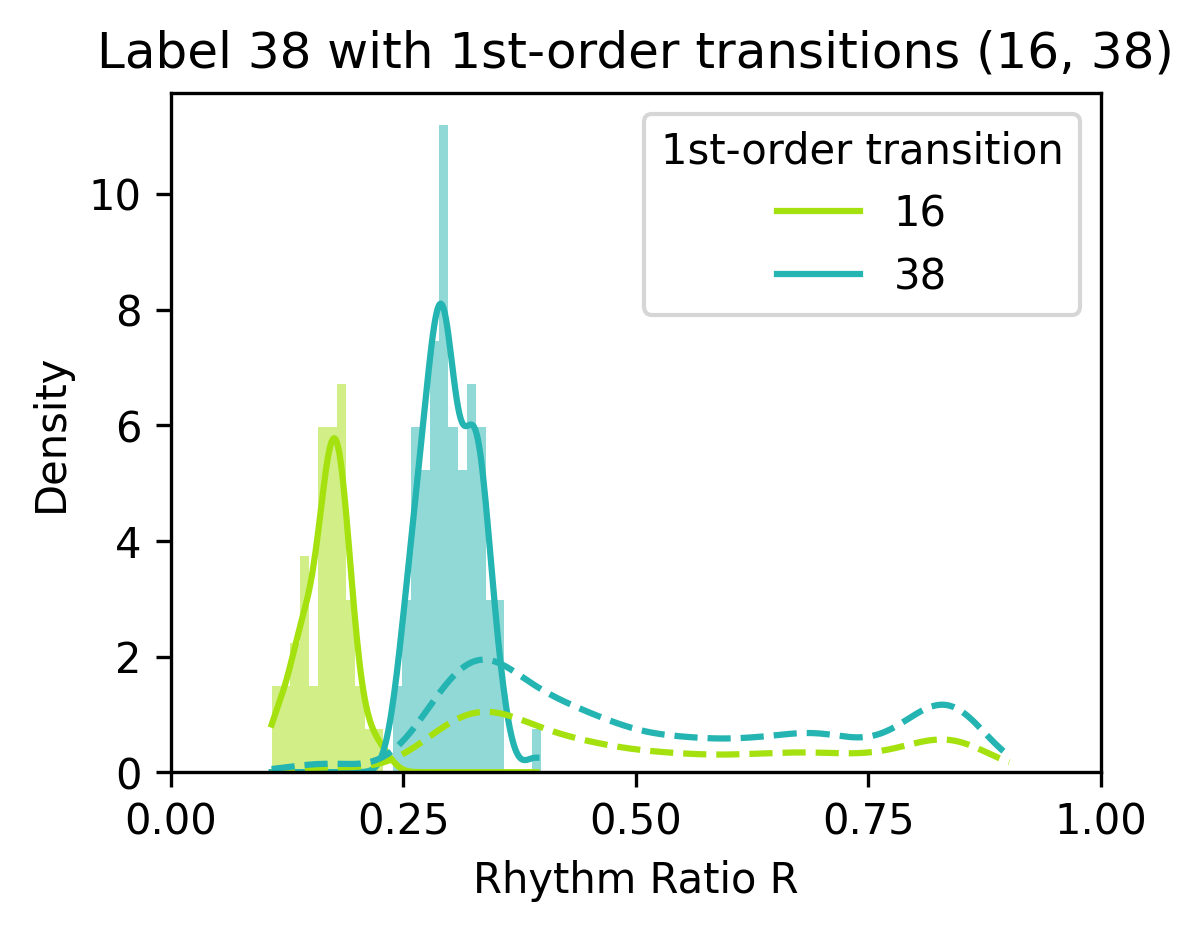

In [52]:
## for every note type and corresponding destinations
for note_type, destination in zip(note_types, destinations):
    ## filter zero-order and its shuffle
    pos1 = dyadic[dyadic['label1'] == note_type]
    pos1_shuffle = dyadic_shuffle[dyadic_shuffle['label1'] == note_type]
    ## filter first_order and its shuffle
    pos2 = pos1[pos1['label2'] == destination[0]].append(pos1[pos1['label2'] == destination[1]])
    pos2_shuffle = pos1_shuffle[pos1_shuffle['label2'] == destination[0]].append(pos1_shuffle[pos1_shuffle['label2'] == destination[1]])
    
    ## graph
    figure(figsize=(4, 3), dpi=300)
       
    x = pos2 
    
    # Create an array with the colors you want to use
    colors = ["#24B4B1", "#A5E10F"]
    # Set your custom color palette
    custom = sns.set_palette(sns.color_palette(colors))
    
    plt.rcParams['patch.edgecolor'] = 'none'
    
    plt.legend(title='1st-order transition', labels = np.unique(pos2['label2']))
    
    sns.histplot(
        data = x,
        binwidth = 0.01,
        x = 'ratio_roeske',
        hue = 'label2',
        kde = True,
        palette = sns.color_palette(colors),
        stat = 'density'
    ).set(title = 'Label ' + str(note_type) + ' with 1st-order transitions ' + str(destination), xlabel = 'Rhythm Ratio R')
    
    x_shuffle = pos2_shuffle
    
    sns.histplot(
        data = x_shuffle,
        binwidth = 0.01,
        x = 'ratio_roeske',
        hue = 'label2',
        kde = True,
        palette = sns.color_palette(colors),
        alpha = 0,
        stat = 'density',
        line_kws = dict(linestyle = 'dashed')
    )
    
    
    ax = plt.gca()
    ax.set_xlim([0, 1])
    plt.xticks(np.arange(0, 1.25, 0.25))
    
    plt.legend(title='1st-order transition', labels = np.unique(pos2['label2']))
    
    #ax.set_ylim([0, 100])
    
    from butcherbird.utils.paths import FIGURE_DIR
    
    figname = str(indv) + '_' + str(note_type) + '_' + str(destination) + ".pdf"
    
    plt.savefig(FIGURE_DIR/'first_order'/str(indv)/figname)
    plt.show()
    